In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Create our list of stopwords
nlp = spacy.load('en_core_web_lg')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [7]:
df = pd.read_csv('TrainingDS.csv')
df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
df.head()

,ID,Text,Class
0,1,Trump supporters needed to say the 4 Democrats...,0
1,2,Send them back!!Why the hell are they even her...,1
2,3,Yeah...Im wondering if send them back works fo...,1
3,4,I know you realize you cant pretend that you d...,1
4,5,"Donny, you owe all people an apology for appla...",0


In [8]:
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in df['Text']])
    
doc_vectors.shape

(1500, 300)

In [59]:
model = Sequential()
model.add(Dense(doc_vectors.shape[1], input_dim=doc_vectors.shape[1]))
model.add(Dense(5000, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2500, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1000, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(500, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [60]:
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [61]:
model.compile(optimizer='nadam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [62]:
history = model.fit(doc_vectors, 
                    df['Class'], 
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[checkpoint_callback])

Epoch 1/10
38/38 [==============================] - 6s 143ms/step - loss: 0.7144 - accuracy: 0.6883 - auc: 0.7234 - val_loss: 0.5150 - val_accuracy: 0.7600 - val_auc: 0.8529

Epoch 00001: val_accuracy improved from -inf to 0.76000, saving model to best_model.h5
Epoch 2/10
38/38 [==============================] - 5s 139ms/step - loss: 0.4242 - accuracy: 0.8050 - auc: 0.8771 - val_loss: 0.7269 - val_accuracy: 0.7200 - val_auc: 0.8584

Epoch 00002: val_accuracy did not improve from 0.76000
Epoch 3/10
38/38 [==============================] - 5s 144ms/step - loss: 0.3840 - accuracy: 0.8275 - auc: 0.9005 - val_loss: 0.5454 - val_accuracy: 0.7533 - val_auc: 0.8665

Epoch 00003: val_accuracy did not improve from 0.76000
Epoch 4/10
38/38 [==============================] - 5s 144ms/step - loss: 0.3621 - accuracy: 0.8258 - auc: 0.9088 - val_loss: 0.5965 - val_accuracy: 0.7867 - val_auc: 0.8736

Epoch 00004: val_accuracy improved from 0.76000 to 0.78667, saving model to best_model.h5
Epoch 5/10
38

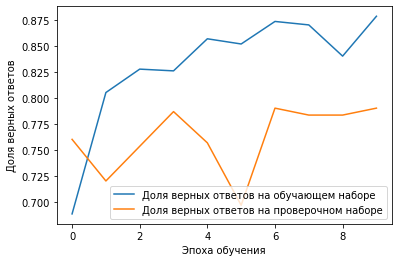

In [63]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [65]:
with nlp.disable_pipes():
    doc_vectors_test = np.array([nlp(text).vector for text in df_test.Text])
doc_vectors_test.shape

(500, 300)

In [66]:
model.load_weights(model_save_path)
test_predict = model.predict(doc_vectors_test)
test_predict = np.where(test_predict >= 0.5,1,0)

In [67]:
df_test['Class'] = test_predict
df_test.head()

,ID,Text,Class
0,1,Ye bhi illegal immigrant lag rahi hai -- NRC r...,0
1,2,Yeah I asked someone about her skirt today and...,0
2,3,You need to clean your SELECTIVE HEARING COBWE...,0
3,4,It easy to complain and criticize with no offe...,1
4,5,Guess the send-them-back policy of your friend...,1


In [68]:
df_test.drop('Text', axis=1).to_csv('test_sp_nn.csv', index=False, sep=',')